RankNet is one of the compound networks for RecSys problems. It's also called **point-wise** approach to ranking (there's also **pairwise** and **listwise**), because we compare each $j$ item with a single one $i$ from the set and estimate the probability of $P(item_i>item_j)$. For the matter of working with two separate vectors simultaneously RankNet is also called a **Siamese neural network**.

#### How do we label probabilities (lets call them labels) for training?
We assign $label_{ij}$ to each pair the following way:
* $P(label_{ij}|item_i>item_j)=1$
* $P(label_{ij}|item_i=item_j)=0.5$
* $P(label_{ij}|item_i<item_j)=0$

#### A trick behind getting probabilities
In RankNet we're getting predictions by calculating a differnce in NN outputs between pairs and applying sigmoid ontop of the result: $p_{ij}=\sigma(f(X_i)-f(X_j))=\frac{exp(f(X_i)-f(X_j))}{1+exp(f(X_i)-f(X_j))}$, therefore scaling everything into $[0; 1]$ range and allowing learning with BCE

#### What exactly are we optimizing?
We're optimizing a classic log-likelihood, or, if we use DL lingo, binary cross-entropy, which you can find in `ml/supervised/logistic`, as well gradient derivations for it.

#### How is the model approximately looking?
Model's lifecycle can be roughly described in the following diagram:

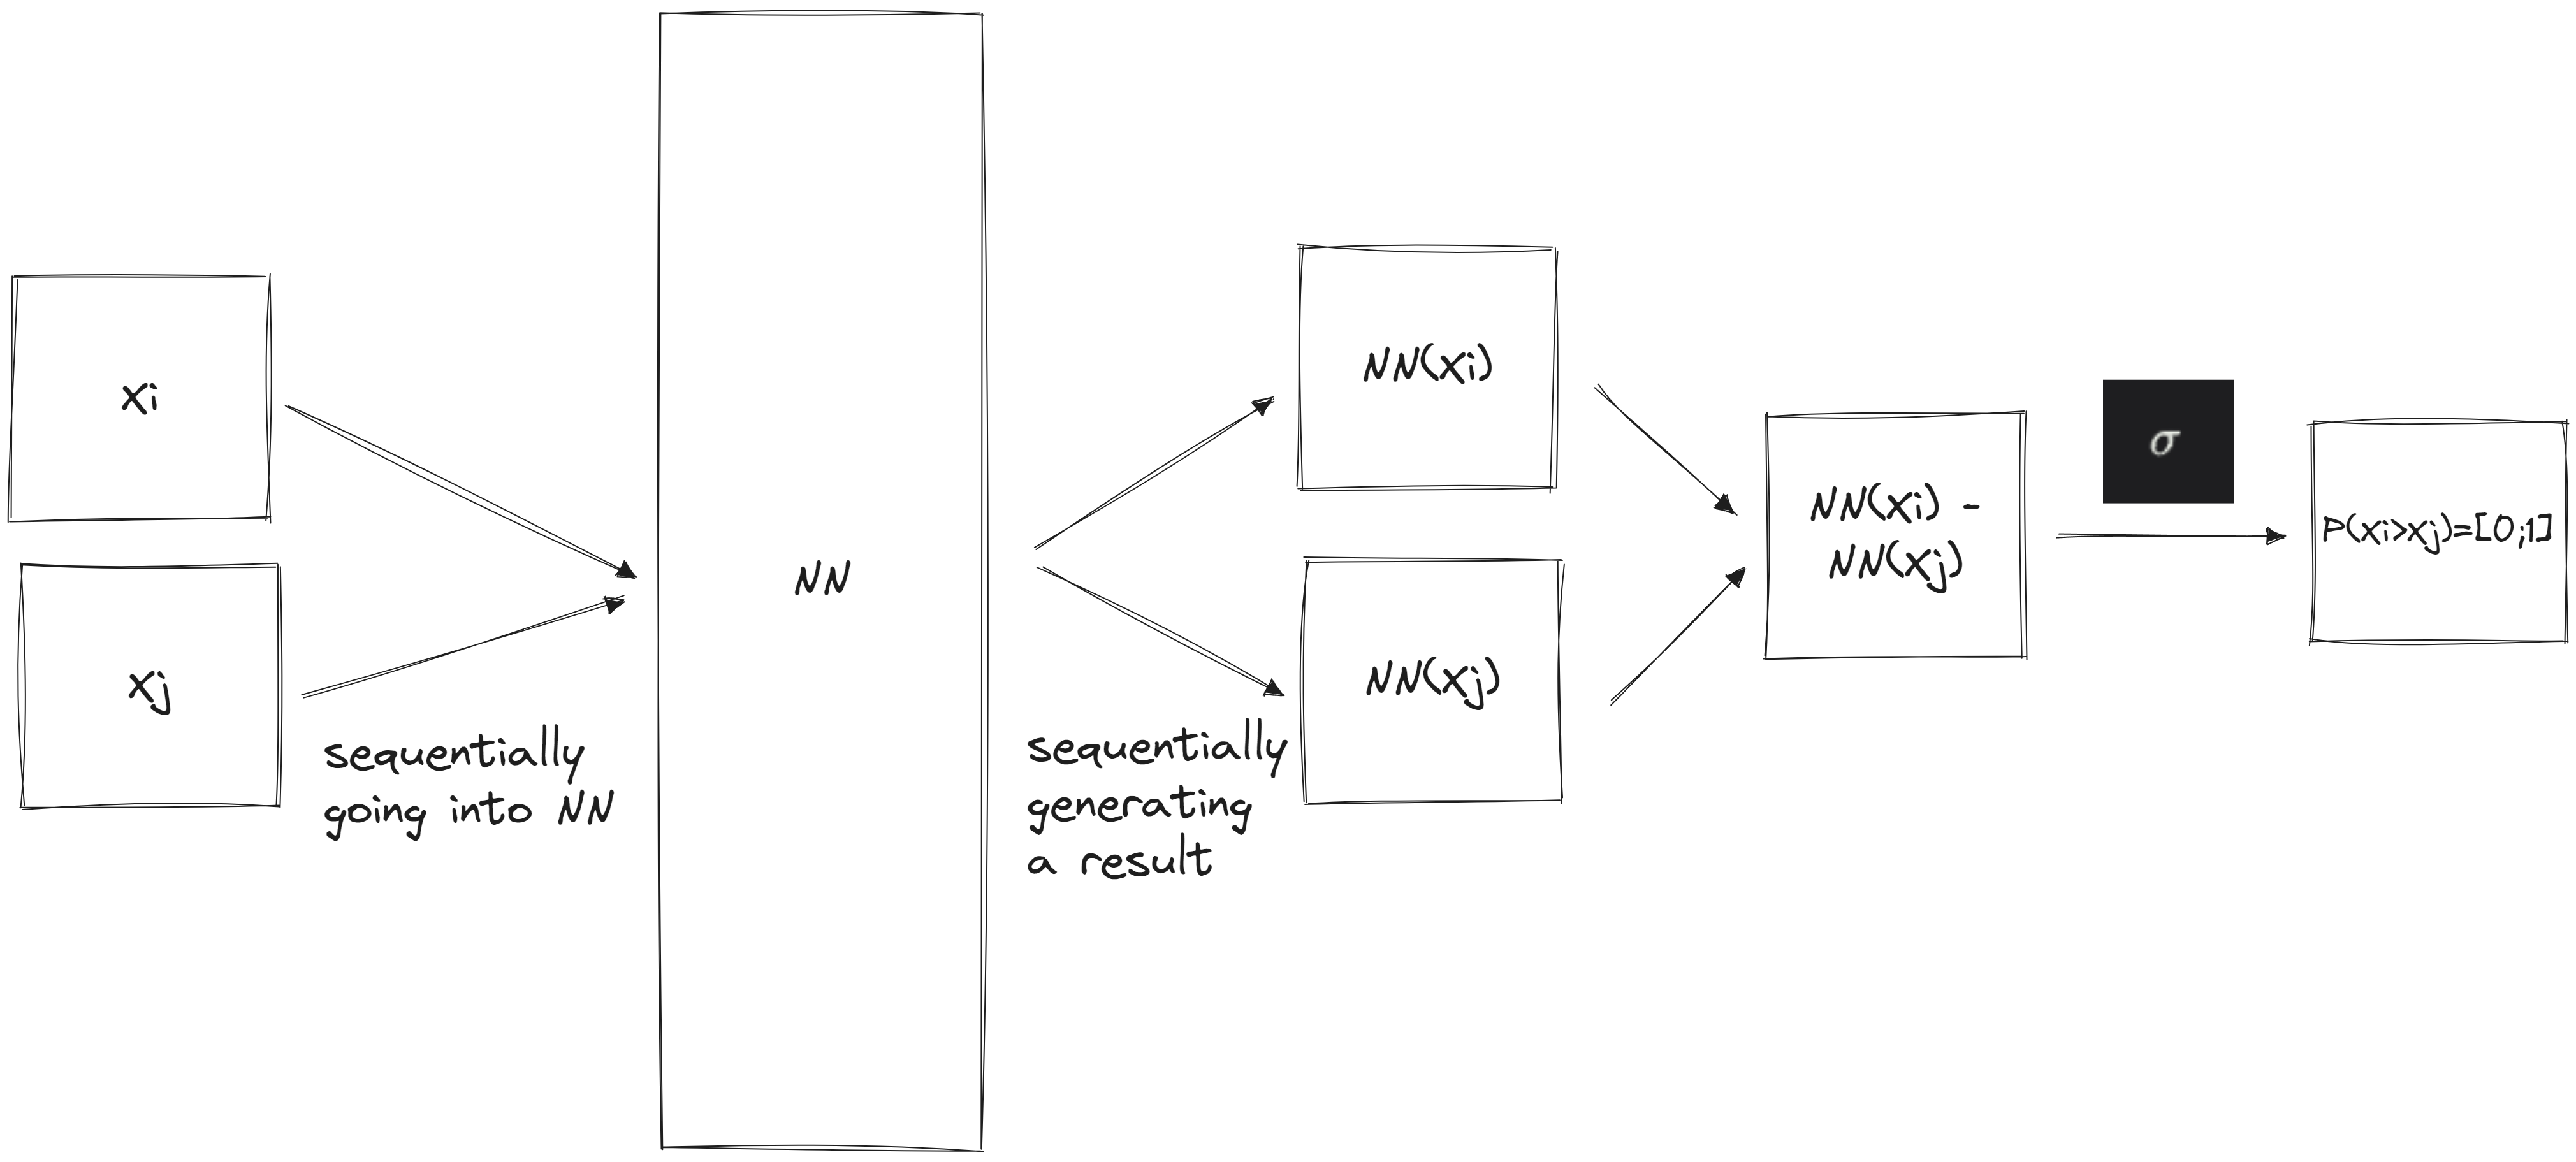

#### Generating synthetic data
There aren't many ranking datasets in the wild, therfore, for the sake of simplicity, we're just going to **generate** random pairs. Suppose we're dealing with ranking search results amongst documents against some user-based queries. That means that we'll have generate several vectors:
* `D`: a 2d vector of documents' features
* `S`: ground-truth ranks of each document pair

In [4]:
import torch
from torch.utils import data

class PairwiseRankingsGen(data.Dataset):

    def __init__(self, factors_d: int, doc_num: int) -> None:
        """ 
        Ranking dataset with single strata. 
        Batching is not feasible, since it's already overcomplicated
        It is used for getting all possible pairs for a single item
        and is meant to be iterated over to create a full dataset of
        pairs (as seen below)
        """

        super().__init__()

        self.doc_num = doc_num
        self.D = torch.rand((doc_num, factors_d))
        self.S = torch.randint(0,5,size=(doc_num, ))

    def __len__(self):
        return len(self.S)
    
    def __getitem__(self, index):
        try:
            stop, start = 0 if index.stop is None else index.stop, \
                0 if index.stop is None else index.stop
            indexedDataSize = stop - start
        except:
            indexedDataSize = 1

        # creating vectors X_i and X_j
        # NOT recommended, since we're generating
        # random pairs on each iteration
        X_i = self.D[index, :]
        randomPairs = torch.multinomial(torch.arange(0,self.__len__(),
                                                     dtype=torch.float), 
                            indexedDataSize, replacement=True) 
        X_j = self.D[randomPairs,:]

        # generating probabilities
        S_i, S_j = self.S[index], self.S[randomPairs]
        P_ij = (S_i == S_j).type(torch.long) * .5
        P_ij += (S_i > S_j).type(torch.long)
        
        return (
            X_i, X_j, P_ij
        )

class rankDS(data.Dataset):

    def __init__(self, factors_d: int, n_pairs: int):
        """
        Generate arbitrary dataset of document pairs
        with their appropriate probabilities of P(rank(i)>rank(j))
        (not guaranteed to be different)
        - factors_d: int
            - number of latent factors for documents
        - n_pairs: int
            - number of possible pairs (also can be referred as
            the max number of documents)
        """
        self.factors_d = factors_d
        self.n_pairs = n_pairs
        self.generator = PairwiseRankingsGen(factors_d,n_pairs)
        
        # populating the dataset by generating random pairs
        self.Xi = []
        self.Xj = []
        self.Pij = []
        for idx in range(n_pairs):
            X_i, X_j, probas = self.generator[idx]
            self.Xi.append(X_i)
            self.Xj.append(X_j)
            self.Pij.append(probas)
        self.Pij = torch.hstack(self.Pij)
        self.Xi, self.Xj = torch.vstack(self.Xi), \
            torch.vstack(self.Xj)

    def __len__(self):
        return self.n_pairs

    def __getitem__(self, index):
        return (
            self.Xi[index],
            self.Xj[index],
            self.Pij[index]
        )

# creating pairs
d_num = 10_000
latent_dims = 16
ds = rankDS(latent_dims,d_num)
ds[1]

(tensor([0.8848, 0.6819, 0.7394, 0.7961, 0.1288, 0.3061, 0.3011, 0.3492, 0.6991,
         0.9441, 0.3164, 0.9798, 0.1938, 0.5366, 0.9484, 0.2126]),
 tensor([0.1870, 0.7298, 0.5443, 0.0451, 0.5185, 0.0416, 0.1241, 0.8264, 0.1751,
         0.5367, 0.1323, 0.4800, 0.3253, 0.6933, 0.5410, 0.9999]),
 tensor(0.))

Introducing batching with dataloaders

In [13]:
# splitting randomly initial dataset
train_sample_size = int(len(ds) * .75)
test_sample_size = len(ds) - train_sample_size
train, test = data.random_split(ds, [
    train_sample_size, test_sample_size
])

# batching data via the DataLoader
batch_size = 8
train_dl = data.DataLoader(train,batch_size=batch_size,
                                    shuffle=True, num_workers=0)
test_dl = data.DataLoader(test,batch_size=batch_size,
                                    shuffle=False, num_workers=0)
len(train_dl), len(test_dl)

(938, 313)

#### Building a trivial RankNet model


In [18]:
from torch import nn

class RankNet(nn.Module):

    def __init__(self, input_d, hid_d):
        super().__init__()
        self.NNi = nn.Linear(input_d, hid_d)
        self.NNj = nn.Linear(input_d, hid_d)
        self.outLayer = nn.Linear(hid_d, 1)
        self.GeLU = nn.GELU()
        
    def forward(self, xi, xj):
        xi = self.GeLU(self.NNi(xi))
        xj = self.GeLU(self.NNj(xj))
        out = self.outLayer(torch.sub(xi, xj))
        return torch.sigmoid(out)

#### Settting up and running training

In [30]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = RankNet(latent_dims, 32).to(device)
model

RankNet(
  (NNi): Linear(in_features=16, out_features=32, bias=True)
  (NNj): Linear(in_features=16, out_features=32, bias=True)
  (outLayer): Linear(in_features=32, out_features=1, bias=True)
  (GeLU): GELU(approximate='none')
)

In [31]:
trainParams = {
    'lr': .001,
    'max_epochs': 50,
    'sgdMomentum': .005,
    'verbose': 1
}

# not BCEwithlogitloss, since we apply sigmoid ourselves
criterion = nn.BCELoss().to(device) 
optimizer = torch.optim.SGD(model.parameters(), lr=trainParams['lr'],
                            momentum=trainParams['sgdMomentum'])
adamOptimizer = torch.optim.Adam(model.parameters(), lr=trainParams['lr'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, patience=10)

In [32]:
from tqdm import tqdm
import numpy as np

av_losses = []

for epoch in range(trainParams['max_epochs']):
    losses = []
    for batch in tqdm(train_dl):
        optimizer.zero_grad()

        xiBatch, xjBatch, pijBatch = batch
        xiBatch = xiBatch.to(device)
        xjBatch = xjBatch.to(device)
        out = model(xiBatch,xjBatch)

        loss = criterion(out.squeeze(), pijBatch.to(device))
        losses.append(loss.item())
        scheduler.step(loss)
        loss.backward()
        adamOptimizer.step()

    av_losses.append(np.array(losses).mean())
    if epoch % trainParams['verbose'] == 0:
        print(f'epoch: {epoch+1} :: av. BCE: {av_losses[-1]}')

100%|██████████| 938/938 [00:01<00:00, 504.25it/s]


epoch: 1 :: av. BCE: 0.6942127539532017


100%|██████████| 938/938 [00:01<00:00, 580.42it/s]


epoch: 2 :: av. BCE: 0.6923498813785723


100%|██████████| 938/938 [00:01<00:00, 585.73it/s]


epoch: 3 :: av. BCE: 0.6913599345221448


100%|██████████| 938/938 [00:01<00:00, 576.81it/s]


epoch: 4 :: av. BCE: 0.6916756072024038


100%|██████████| 938/938 [00:01<00:00, 599.14it/s]


epoch: 5 :: av. BCE: 0.6911880476896697


100%|██████████| 938/938 [00:01<00:00, 597.28it/s]


epoch: 6 :: av. BCE: 0.6910324134806326


100%|██████████| 938/938 [00:01<00:00, 586.47it/s]


epoch: 7 :: av. BCE: 0.6906834580877951


100%|██████████| 938/938 [00:01<00:00, 590.01it/s]


epoch: 8 :: av. BCE: 0.6906113589623335


100%|██████████| 938/938 [00:01<00:00, 588.90it/s]


epoch: 9 :: av. BCE: 0.6904615721087466


100%|██████████| 938/938 [00:01<00:00, 573.82it/s]


epoch: 10 :: av. BCE: 0.6901078464379952


100%|██████████| 938/938 [00:01<00:00, 597.32it/s]


epoch: 11 :: av. BCE: 0.6896763865246194


100%|██████████| 938/938 [00:01<00:00, 585.96it/s]


epoch: 12 :: av. BCE: 0.6889849943774087


100%|██████████| 938/938 [00:01<00:00, 602.23it/s]


epoch: 13 :: av. BCE: 0.6890139253790191


100%|██████████| 938/938 [00:01<00:00, 602.42it/s]


epoch: 14 :: av. BCE: 0.688636599382612


100%|██████████| 938/938 [00:01<00:00, 596.64it/s]


epoch: 15 :: av. BCE: 0.6878137164659845


100%|██████████| 938/938 [00:01<00:00, 588.21it/s]


epoch: 16 :: av. BCE: 0.6872521163558146


100%|██████████| 938/938 [00:01<00:00, 570.11it/s]


epoch: 17 :: av. BCE: 0.6866856761959824


100%|██████████| 938/938 [00:01<00:00, 601.41it/s]


epoch: 18 :: av. BCE: 0.6858725127126617


100%|██████████| 938/938 [00:01<00:00, 589.76it/s]


epoch: 19 :: av. BCE: 0.6852481297846796


100%|██████████| 938/938 [00:01<00:00, 581.05it/s]


epoch: 20 :: av. BCE: 0.6850706912688355


100%|██████████| 938/938 [00:01<00:00, 606.64it/s]


epoch: 21 :: av. BCE: 0.6843500936717621


100%|██████████| 938/938 [00:01<00:00, 576.98it/s]


epoch: 22 :: av. BCE: 0.6837544992153071


100%|██████████| 938/938 [00:01<00:00, 590.53it/s]


epoch: 23 :: av. BCE: 0.6832436732391813


100%|██████████| 938/938 [00:01<00:00, 598.93it/s]


epoch: 24 :: av. BCE: 0.6829782550904289


100%|██████████| 938/938 [00:01<00:00, 584.89it/s]


epoch: 25 :: av. BCE: 0.6824025679498847


100%|██████████| 938/938 [00:01<00:00, 598.13it/s]


epoch: 26 :: av. BCE: 0.6818363042528441


100%|██████████| 938/938 [00:01<00:00, 577.60it/s]


epoch: 27 :: av. BCE: 0.6816573395912073


100%|██████████| 938/938 [00:01<00:00, 595.41it/s]


epoch: 28 :: av. BCE: 0.681216134509044


100%|██████████| 938/938 [00:01<00:00, 595.19it/s]


epoch: 29 :: av. BCE: 0.6808492040583319


100%|██████████| 938/938 [00:01<00:00, 594.74it/s]


epoch: 30 :: av. BCE: 0.6804747507134988


100%|██████████| 938/938 [00:01<00:00, 614.46it/s]


epoch: 31 :: av. BCE: 0.6798410385148104


100%|██████████| 938/938 [00:01<00:00, 580.21it/s]


epoch: 32 :: av. BCE: 0.6794390079817538


100%|██████████| 938/938 [00:01<00:00, 588.73it/s]


epoch: 33 :: av. BCE: 0.679361945848221


100%|██████████| 938/938 [00:01<00:00, 596.96it/s]


epoch: 34 :: av. BCE: 0.6787608304003409


100%|██████████| 938/938 [00:01<00:00, 702.21it/s]


epoch: 35 :: av. BCE: 0.6784555586035064


100%|██████████| 938/938 [00:01<00:00, 645.61it/s]


epoch: 36 :: av. BCE: 0.6776858011542607


100%|██████████| 938/938 [00:01<00:00, 632.70it/s]


epoch: 37 :: av. BCE: 0.6773815148039413


100%|██████████| 938/938 [00:01<00:00, 625.62it/s]


epoch: 38 :: av. BCE: 0.6770025461213167


100%|██████████| 938/938 [00:01<00:00, 579.28it/s]


epoch: 39 :: av. BCE: 0.67691997341764


100%|██████████| 938/938 [00:01<00:00, 632.85it/s]


epoch: 40 :: av. BCE: 0.6759713151688769


100%|██████████| 938/938 [00:01<00:00, 657.87it/s]


epoch: 41 :: av. BCE: 0.6751212177119021


100%|██████████| 938/938 [00:01<00:00, 591.24it/s]


epoch: 42 :: av. BCE: 0.6753176918416135


100%|██████████| 938/938 [00:01<00:00, 585.00it/s]


epoch: 43 :: av. BCE: 0.6754205830252247


100%|██████████| 938/938 [00:01<00:00, 626.28it/s]


epoch: 44 :: av. BCE: 0.6745388266374307


100%|██████████| 938/938 [00:01<00:00, 611.91it/s]


epoch: 45 :: av. BCE: 0.6736068724950494


100%|██████████| 938/938 [00:01<00:00, 595.43it/s]


epoch: 46 :: av. BCE: 0.6737679768599936


100%|██████████| 938/938 [00:01<00:00, 588.89it/s]


epoch: 47 :: av. BCE: 0.6730177040293273


100%|██████████| 938/938 [00:01<00:00, 578.07it/s]


epoch: 48 :: av. BCE: 0.6727298135950621


100%|██████████| 938/938 [00:01<00:00, 605.66it/s]


epoch: 49 :: av. BCE: 0.6725682597170507


100%|██████████| 938/938 [00:01<00:00, 572.45it/s]

epoch: 50 :: av. BCE: 0.6721524084681896


Displaying dynamic of the average BCE over epochs

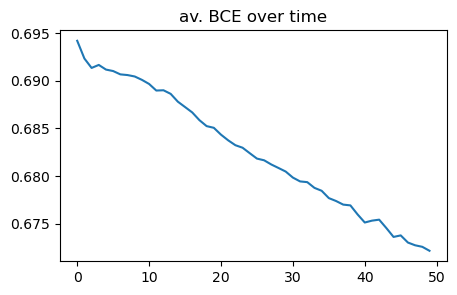

In [39]:
import matplotlib.pyplot as plt

plt.plot(av_losses)
plt.title('av. BCE over time')
plt.rcParams["figure.figsize"] = (5,3)

#### Testing out the model on the training set of the data

In [54]:
preds = []
truths = []

model.eval()
for tdata in tqdm(test):
    xi, xj, pij = tdata
    truths.append(pij)
    with torch.no_grad():
        out = model(xi.to(device),xj.to(device)).squeeze()
        preds.append(out.cpu().detach())
model.train()

100%|██████████| 2500/2500 [00:01<00:00, 1705.05it/s]


RankNet(
  (NNi): Linear(in_features=16, out_features=32, bias=True)
  (NNj): Linear(in_features=16, out_features=32, bias=True)
  (outLayer): Linear(in_features=32, out_features=1, bias=True)
  (GeLU): GELU(approximate='none')
)

In [55]:
# getting distribution of predicted probabilities
preds = torch.vstack(preds)
preds.shape, len(test)

(torch.Size([2500, 1]), 2500)

In [59]:
# getting distribution of actual ground-truth probabilities
truths = torch.vstack(truths).squeeze().round().type(torch.int)
truths[:2]

tensor([1, 0], dtype=torch.int32)

For a synthetic and quite inefficient data RankNet's results look quite promising of over $50\%$ accurate hits:

In [62]:
acc = (preds.squeeze().round().type(torch.int) == truths).sum() / len(test)
print('RankNet accuracy:',acc)

RankNet accuracy: tensor(0.5088)
